<a href="https://colab.research.google.com/github/bwsi-hadr/08-graph-optimization-tsp-obhalerao/blob/master/Omkar_Bhalerao_TSP_Solutions.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
import networkx as nx
try:
  import osmnx as ox
except:
  # osmnx depends on the system package libspatialindex
  !apt install libspatialindex-dev
  !pip install osmnx
  import osmnx as ox

try: 
  import geopandas as gpd
except: 
  !pip install geopandas 
  import geopandas as gpd
  
try:
  import contextily as ctx 
except:
  # install dependencies for contextily
  !apt install libproj-dev proj-data proj-bin
  !apt install libgeos-dev
  !pip install cython
  !pip install cartopy
  # install contextily
  !pip install contextily==1.0rc1 --no-use-pep517 --no-cache-dir
  import contextily as ctx
  
import fiona
from shapely.geometry import Point, LineString, Polygon
  
import gdal
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pathlib

In [0]:
from shapely import ops

# Traveling Salesman Problem
The canonical Traveling Salesman Problem is stated as:
>  "Given a list of cities and the distances between each pair of cities, what is the shortest possible route that visits each city and returns to the origin city?"

This is generalizable to finding the shortest [Hamiltonian cycle](http://mathworld.wolfram.com/HamiltonianCycle.html) on a fully connected graph (i.e. all nodes can be reached from all other nodes).

This problem is [NP-hard](https://en.wikipedia.org/wiki/P_versus_NP_problem), meaning it is not possible for an algorithm to solve all instances of the problem quickly (i.e. in polynomial time). However, there are many approximate and heuristic approaches which can give reasonable solutions in shorter time.

In [0]:
place_name = 'Cambridge, MA, United States'
place_roads = ox.graph_from_place(place_name)


In [0]:
place_roads_nodes, place_roads_edges = ox.graph_to_gdfs(place_roads)

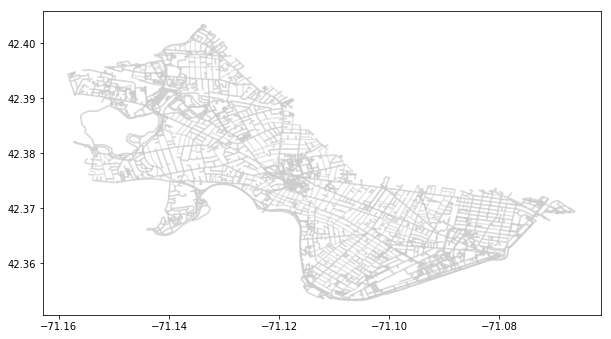

In [8]:
fig = plt.figure(figsize=[10,10])
ax = fig.add_subplot(1,1,1)
place_roads_edges.plot(ax=ax, color=[0.8, 0.8, 0.8], alpha=0.5)

Let's say you wanted to do a ice cream crawl: you want to visit every ice cream shop in a city. What is the shortest route that you would take that takes you to every ice cream shop in a city and brings you back to your starting point?

In [9]:
place_ice_cream = ox.pois_from_place(place_name, amenities=['bar'])
place_ice_cream

,addr:city,addr:housenumber,addr:postcode,addr:state,addr:street,amenity,drink:wine,ele,element_type,geometry,name,opening_hours,osmid,outdoor_seating,phone,smoking,url,website,wheelchair,building,gay,lgbtq,nodes,postal_code
981484250,Cambridge,738,02139,NaN,Massachusetts Avenue,bar,NaN,NaN,node,POINT (-71.1052914 42.366126),Cantab Lounge,NaN,981484250,NaN,NaN,NaN,http://www.cantab-lounge.com/,NaN,limited,NaN,NaN,NaN,NaN,NaN
1907895917,Cambridge,90,02142,MA,Broadway,bar,NaN,NaN,node,POINT (-71.08732929999999 42.363702),Mead Hall,"Mo-Sa 11:30-01:00, Su 15:00-24:00",1907895917,no,+1 617 714 4372,NaN,NaN,https://themeadhall.com/,no,NaN,NaN,NaN,NaN,NaN
2130009488,NaN,567,02139,NaN,Massachusetts Avenue,bar,NaN,NaN,node,POINT (-71.10245930000001 42.3648573),Brick & Mortar,NaN,2130009488,NaN,NaN,NaN,NaN,https://www.brickandmortarbar.com/,NaN,NaN,NaN,NaN,NaN,NaN
2700809528,Boston,149,02114,NaN,Charles Street,bar,NaN,NaN,node,POINT (-71.0706857 42.360447),Beacon Hill Pub,NaN,2700809528,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2707976359,Cambridge,795,02139,NaN,Main Street,bar,NaN,NaN,node,POINT (-71.09712740000001 42.3633583),Cuchi Cuchi,NaN,2707976359,NaN,NaN,NaN,NaN,https://cuchicuchi.cc/,NaN,NaN,NaN,NaN,NaN,NaN
2966948876,Somerville,3,02143,NaN,Beacon Street,bar,NaN,NaN,node,POINT (-71.1015002 42.3744435),Parlor Sports,Mo-Fr 18:00-01:00; Sa-Su 00:00-01:00,2966948876,NaN,NaN,no,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3067171278,Somerville,NaN,NaN,NaN,Sanborn Court,bar,NaN,NaN,node,POINT (-71.0943561 42.3799556),Backbar,NaN,3067171278,NaN,NaN,NaN,NaN,https://backbarunion.com/,NaN,NaN,NaN,NaN,NaN,NaN
3445709783,Allston,116,02134,MA,Brighton Avenue,bar,NaN,NaN,node,POINT (-71.1307542 42.3526314),The White Horse,11:30-2:00,3445709783,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3772735572,NaN,NaN,NaN,NaN,NaN,bar,NaN,NaN,node,POINT (-71.0862671 42.3890185),Casey's,NaN,3772735572,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4267278518,NaN,NaN,NaN,NaN,NaN,bar,NaN,NaN,node,POINT (-71.12289440000001 42.372203),Regattabar,NaN,4267278518,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [10]:
place_ice_cream["geometry"] = place_ice_cream.centroid
ice_cream_nodes = ox.get_nearest_nodes(place_roads, place_ice_cream.geometry.x, place_ice_cream.geometry.y)
ice_cream_nodes

array([  61327348, 6264380257,   61327180, 3024196130,   61327113,
         61325478,   61321641, 3687653201,   61325597,   61329191,
         61329191,   61324660, 2691916176, 2691916176, 2691916176,
         61324660, 3687653201,   61323047, 5493351702,   61325553,
         61327517,   61324864, 5458830470,   61326119])

## Exercise
Plot the locations of the ice cream shops on the map of the roads

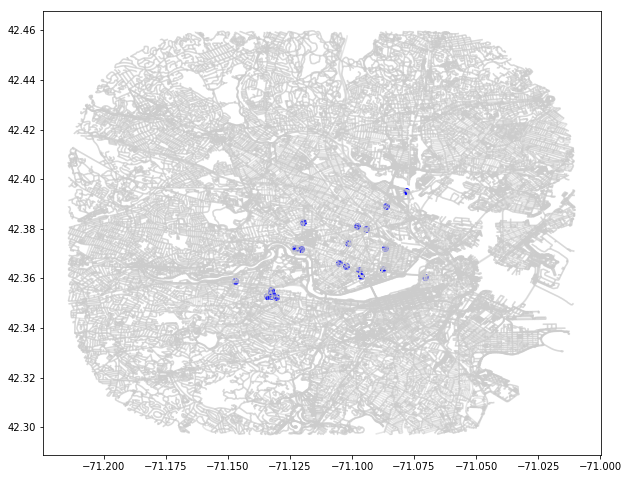

In [43]:
fig = plt.figure(figsize=[10,10])
ax = fig.add_subplot(1,1,1)
place_roads_edges.plot(ax=ax, color=[0.8, 0.8, 0.8], alpha=0.5)
place_ice_cream.plot(ax=ax, color="BLUE", alpha=1.0)

In [0]:
cambridge_bounds = Polygon.from_bounds(*place_roads_edges.total_bounds)



In [0]:
cambridge_bounds = cambridge_bounds.buffer(0.05)
place_roads = ox.graph_from_polygon(cambridge_bounds)

## Compute shortest path matrix

In [0]:
shortest_path_matrix = np.zeros([len(ice_cream_nodes),len(ice_cream_nodes)])
for idx_i, orig in enumerate(ice_cream_nodes):
  for idx_j, dest in enumerate(ice_cream_nodes):
    shortest_path_matrix[idx_i, idx_j] = nx.shortest_path_length(place_roads, orig, dest, weight='length')


In [0]:
ice_cream_graph = nx.from_numpy_matrix(shortest_path_matrix, create_using=nx.MultiDiGraph)

In [241]:
# new graph indexes from 0
ice_cream_graph.nodes

NodeView((0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23))

In [242]:
# rename node labels using original labels
relabel_dict = {k:v for k, v in zip(ice_cream_graph.nodes, ice_cream_nodes)}
ice_cream_graph = nx.relabel_nodes(ice_cream_graph, relabel_dict)
ice_cream_graph.nodes
relabel_dict

{0: 61327348,
 1: 6264380257,
 2: 61327180,
 3: 3024196130,
 4: 61327113,
 5: 61325478,
 6: 61321641,
 7: 3687653201,
 8: 61325597,
 9: 61329191,
 10: 61329191,
 11: 61324660,
 12: 2691916176,
 13: 2691916176,
 14: 2691916176,
 15: 61324660,
 16: 3687653201,
 17: 61323047,
 18: 5493351702,
 19: 61325553,
 20: 61327517,
 21: 61324864,
 22: 5458830470,
 23: 61326119}

## Exercise
Find the best TSP path you can

In [245]:
#Method 1: Greedy Algorithm
import random
rem_nodes = set(range(shortest_path_matrix.shape[0]))

    
start = random.randint(0, shortest_path_matrix.shape[0]-1)
path = [start]
rem_nodes.remove(start)
old = start
while rem_nodes:
  nxt = np.argmin([i if idx in rem_nodes else float('inf') for idx, i in enumerate(shortest_path_matrix[old])])
  path.append(nxt)
  rem_nodes.remove(nxt)
  old = nxt
path.append(start)
print(f"Initial path: {path}")
length = 0
for i, j in zip(path[:-1], path[1:]):
  #print(shortest_path_matrix[i,j])
  length += shortest_path_matrix[i,j]
print(f"Initial path length: {length}")

  

Initial path: [13, 12, 14, 7, 16, 2, 0, 4, 22, 1, 3, 18, 17, 8, 6, 21, 5, 20, 9, 10, 19, 23, 11, 15, 13]
Initial path length: 22668.887


In [247]:
#Method 2: Greedy Algorithm with 2-opt swapping


def distance(path, shortest_path_matrix):
  length = 0
  for i, j in zip(path[:-1], path[1:]):
    length += shortest_path_matrix[i,j]
  return length
  

def opt(route, i, j):
  new_path = []
  for q in range(i):
    new_path.append(path[q])
  for q in range(j, i-1, -1):
    new_path.append(path[q])
  for q in range(j+1, len(path)):
    new_path.append(path[q])
  return new_path

def swap(path, shortest_path_matrix):
  new_path = []
  for i in range(1, len(path)-1):
    for j in range(i+1, len(path)-1):
      new_path = opt(path, i, j)
      if(distance(new_path, shortest_path_matrix) < distance(path, shortest_path_matrix)):
        return new_path
  return None

import random
rem_nodes = set(range(shortest_path_matrix.shape[0]))

    
start = random.randint(0, shortest_path_matrix.shape[0]-1)
start = 0
path = [start]
rem_nodes.remove(start)
old = start
while rem_nodes:
  nxt = np.argmin([i if idx in rem_nodes else float('inf') for idx, i in enumerate(shortest_path_matrix[old])])
  path.append(nxt)
  rem_nodes.remove(nxt)
  old = nxt
path.append(start)
print(f"Initial path: {path}")
length = 0
for i, j in zip(path[:-1], path[1:]):
  #print(shortest_path_matrix[i,j])
  length += shortest_path_matrix[i,j]
print(f"Initial path length: {length}")

count = 0
improve = True
while True:
  k = swap(path, shortest_path_matrix)
  if not k: break
  path = k
  count+=1
  #print(distance(path))
  
print(f"Final path: {path}")
print(f"Final path length: {distance(path, shortest_path_matrix)}")
print(f"{count} 2-opt swap(s).")
    

Initial path: [0, 2, 4, 22, 1, 3, 18, 17, 8, 6, 21, 5, 20, 9, 10, 19, 12, 13, 14, 7, 16, 23, 11, 15, 0]
Initial path length: 23693.831
Final path: [0, 2, 4, 22, 1, 3, 18, 17, 8, 6, 21, 5, 20, 15, 11, 23, 9, 10, 19, 12, 13, 14, 7, 16, 0]
Final path length: 21475.323000000004
4 2-opt swap(s).


In [205]:
#Method 3: Optimized 2-opt swapping: consider longest paths first

def distance(path, shortest_path_matrix):
  length = 0
  for i, j in zip(path[:-1], path[1:]):
    length += shortest_path_matrix[i,j]
  return length
  

def opt(route, i, j):
  new_path = []
  for q in range(i):
    new_path.append(path[q])
  for q in range(j, i-1, -1):
    new_path.append(path[q])
  for q in range(j+1, len(path)):
    new_path.append(path[q])
  return new_path

def swap_better(path, shortest_path_matrix, dists):
  new_path = []
  for i in range(len(dists)):
    for j in range(i+1, len(dists)):
      new_path = opt(path, min(path.index(dists[j]), path.index(dists[i])), max(path.index(dists[j]), path.index(dists[i])))
      if(distance(new_path, shortest_path_matrix) < distance(path, shortest_path_matrix)):
        return new_path
  return None

import random
rem_nodes = set(range(shortest_path_matrix.shape[0]))

start = random.randint(0, shortest_path_matrix.shape[0]-1)
start = 16
path = [start]
rem_nodes.remove(start)
old = start
while rem_nodes:
  nxt = np.argmin([i if idx in rem_nodes else float('inf') for idx, i in enumerate(shortest_path_matrix[old])])
  path.append(nxt)
  rem_nodes.remove(nxt)
  old = nxt
path.append(start)
print(f"Initial path: {path}")
length = 0
for i, j in zip(path[:-1], path[1:]):
  #print(shortest_path_matrix[i,j])
  length += shortest_path_matrix[i,j]
print(f"Initial path length: {length}")

distarr = sorted([(shortest_path_matrix[path[i], path[i+1]], path[i+1]) for i in range(len(path)-2)])
dists = [i[1] for i in distarr]

count = 0
improve = True
while True:
  k = swap_better(path, shortest_path_matrix, dists)
  if not k: break
  path = k
  distarr = sorted([(shortest_path_matrix[path[i], path[i+1]], path[i+1]) for i in range(len(path)-2)])
  dists = [i[1] for i in distarr]
  count+=1
  
  
print(f"Final path: {path}")
print(f"Final path length: {distance(path, shortest_path_matrix)}")
print(f"{count} 2-opt swap(s).")
    


Initial path: [16, 7, 12, 13, 14, 2, 0, 4, 22, 1, 3, 18, 17, 8, 6, 21, 5, 20, 9, 10, 19, 23, 11, 15, 16]
Initial path length: 22857.129
Final path: [16, 0, 2, 4, 22, 1, 3, 18, 17, 8, 6, 21, 5, 20, 15, 11, 23, 9, 10, 19, 14, 13, 12, 7, 16]
Final path length: 21475.322999999997
7 2-opt swap(s).


In [233]:
#Method 4: Simulated Annealing (this is going to be a doozy)

import math

beta = 0.99981

def distance(path, shortest_path_matrix):
  length = 0
  for i, j in zip(path[:-1], path[1:]):
    length += shortest_path_matrix[i,j]
  return length
  

def opt(route, i, j):
  new_path = []
  for q in range(i):
    new_path.append(path[q])
  for q in range(j, i-1, -1):
    new_path.append(path[q])
  for q in range(j+1, len(path)):
    new_path.append(path[q])
  return new_path

def prob(temp, delta):
  if delta < 0: return 1
  return math.exp(-delta / temp)

import random
rem_nodes = set(range(shortest_path_matrix.shape[0]))

temp = 1

start = random.randint(0, shortest_path_matrix.shape[0]-1)
#start = 16
path = [start]
rem_nodes.remove(start)
old = start
while rem_nodes:
  nxt = np.argmin([i if idx in rem_nodes else float('inf') for idx, i in enumerate(shortest_path_matrix[old])])
  path.append(nxt)
  rem_nodes.remove(nxt)
  old = nxt
path.append(start)
print(f"Initial path: {path}")
print(f"Initial path length: {distance(path, shortest_path_matrix)}")

state = path

for i in range(200000):
  if i % 50000 == 0:
    print(f"Iteration {i}")
  t = list(range(1, len(state)-1))
  random.shuffle(t)
  a = t[:2]
  new_state = opt(state, min(a[0], a[1]), max(a[0], a[1]))
  delta = ((distance(new_state, shortest_path_matrix)) - distance(state, shortest_path_matrix))/(distance(state, shortest_path_matrix))
  p = prob(temp, delta)
  if p == 1:
    state = new_state
    continue
  else:
    if random.uniform(0, 1) < p:
      state = new_state
      temp *= beta

print(f"Final path: {state}")
print(f"Final path length: {distance(state, shortest_path_matrix)}")
  



Initial path: [1, 22, 4, 2, 0, 5, 21, 6, 8, 17, 18, 3, 7, 16, 12, 13, 14, 19, 9, 10, 20, 11, 15, 23, 1]
Initial path length: 26761.091
Iteration 0
Iteration 50000
Iteration 100000
Iteration 150000
Final path: [1, 3, 18, 17, 8, 6, 21, 5, 0, 2, 4, 22, 7, 16, 12, 13, 14, 19, 9, 10, 20, 11, 15, 23, 1]
Final path length: 24688.853000000003
